In [2]:
# %tensorflow_version 2.x 
# On Colab, need this to specify tensorflow version
import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc, sys
import cv2

sys.path.append("../tools/")
from helpers import (get_n, get_dummies, resize, plot_loss,
                     MultiOutputDataGenerator, plot_acc,
                    image_from_char)

In [3]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import os
DATA_FOLDER = "../../data/"
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/test_image_data_3.parquet
../../data/train.csv
../../data/test_image_data_1.parquet
../../data/train_image_data_2.parquet
../../data/train_image_data_3.parquet
../../data/test_image_data_2.parquet
../../data/test_image_data_0.parquet
../../data/train_image_data_0.parquet
../../data/class_map.csv
../../data/test.csv
../../data/train_image_data_1.parquet
../../data/sample_submission.csv
../../data/Kalpurush_Fonts/kalpurush-2.ttf


In [5]:
train_df_ = pd.read_csv(DATA_FOLDER+'/train.csv')
test_df_ = pd.read_csv(DATA_FOLDER + '/test.csv')
class_map_df = pd.read_csv(DATA_FOLDER + '/class_map.csv')
sample_sub_df = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [6]:
HEIGHT = 236
WIDTH = 236

### Number of unique values

In [7]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


In [8]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [9]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [15]:
IMG_SIZE=64
N_CHANNELS=1

## Basic Model

In [16]:
def get_model(base_filters=32, nlevels=4, ncov=4, kernel_size=(3,3), 
              activation='relu', momentum=0.15, dropout_rate=0.3,
             pool_size=2):
    keras.backend.clear_session()
    tf.random.set_seed(2040)
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    if activation.lower() == 'leakyrelu':
        activation = keras.layers.LeakyReLU(alpha=0.05)

    model = Conv2D(filters=base_filters, kernel_size=kernel_size, padding='SAME', 
                 activation=activation, 
                 input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
    for _ in range(ncov-1):
        model = Conv2D(filters=base_filters, kernel_size=kernel_size, padding='SAME', 
                   activation=activation)(model)
    model = BatchNormalization(momentum=momentum)(model)
    model = MaxPool2D(pool_size=(pool_size, pool_size), )(model)
#     model = Conv2D(filters=base_filters, kernel_size=(5, 5), padding='SAME',
    model = Conv2D(filters=base_filters, kernel_size=(3, 3), padding='SAME',
                 activation=activation)(model)
    model = Dropout(rate=dropout_rate)(model)
    for i in range(nlevels-1):
        for _ in range(ncov):
            model = Conv2D(filters=2**(i+1)*base_filters, kernel_size=kernel_size, 
                         padding='SAME', activation=activation)(model)
        model = BatchNormalization(momentum=momentum)(model)
        model = MaxPool2D(pool_size=(pool_size, pool_size))(model)
#         model = Conv2D(filters=2**(i+1)*base_filters, kernel_size=(5, 5), 
        model = Conv2D(filters=2**(i+1)*base_filters, kernel_size=(3, 3), 
                       padding='SAME', activation=activation)(model)
        model = BatchNormalization(momentum=momentum)(model)
        model = Dropout(rate=dropout_rate)(model)

    model = Flatten()(model)
    model = Dense(1024, activation = activation)(model)
    model = Dropout(rate=dropout_rate)(model)
    dense = Dense(512, activation = activation)(model)

    head_root = Dense(168, activation = 'softmax', name='root')(dense)
    head_vowel = Dense(11, activation = 'softmax', name='vowel')(dense)
    head_consonant = Dense(7, activation = 'softmax', name='consonant')(dense)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
#     lr = 1e-3
#     opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
#     model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

In [17]:
# model = get_model(base_filters=48, activation='relu', nlevels=3, ncov=4,
#                   kernel_size=(3,3), pool_size=3)
model = get_model(base_filters=32, activation='relu', nlevels=4, ncov=4,
                  kernel_size=(3,3), pool_size=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png');

In [18]:
weights = {'root': 0.7, 'vowel': 0.1, 'consonant':0.2}
lr = 1e-3
opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'],
              loss_weights=weights,)

In [19]:
# Learning rate will be half after 3 epochs if accuracy is not increased
lr_scheduler = []
targets = ['root', 'vowel', 'consonant']
for target in targets:
    lr_scheduler.append(ReduceLROnPlateau(monitor=f'{target}_accuracy', 
                                            patience=3,
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001))
# def exponential_decay(epoch):
#    initial_lr = 0.001
#    k = 0.1
#    lr = initial_lr * np.exp(-k*epoch)
#    return lr

# lrate = keras.callbacks.LearningRateScheduler(exponential_decay)


In [20]:
# batch_size = 256
batch_size = 128
epochs = 30

In [21]:
HEIGHT = 137
WIDTH = 236

In [18]:
# model = get_model(base_filters=48, ncov=3, pool_size=3)
# model.summary()
# model = keras.models.load_model('./saved_models/model_selu_kernel-3_cov-3_basefilter-48_pool-3_3.h5')

In [22]:
histories = []

In [23]:
# for i in [1]:
for i in range(4):
    train_df = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train, size=IMG_SIZE)/255

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    # print(f'Training images: {X_train.shape}')
    # print(f'Training labels root: {Y_train_root.shape}')
    # print(f'Training labels vowel: {Y_train_vowel.shape}')
    # print(f'Training labels consonants: {Y_train_consonant.shape}')


    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        # zca_whitening=True,  # apply ZCA whitening
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    # history = model.fit_generator(datagen.flow(x_train, {'root': y_train_root, 'vowel': 
    history = model.fit(datagen.flow(x_train, {'root': y_train_root, 'vowel':y_train_vowel, 
                                               'consonant': y_train_consonant}, 
                                     batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=lr_scheduler)
    #                           callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)

    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()


  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 360 steps, validate on 4017 samples
Epoch 1/30
360/360 [==============================] - 28s 77ms/step - loss: 3.7709 - root_loss: 4.7491 - vowel_loss: 2.0298 - consonant_loss: 1.2179 - root_accuracy: 0.0326 - vowel_accuracy: 0.2816 - consonant_accuracy: 0.6128 - val_loss: 3.5919 - val_root_loss: 4.5595 - val_vowel_loss: 1.7602 - val_consonant_loss: 1.1110 - val_root_accuracy: 0.0461 - val_vowel_accuracy: 0.3752 - val_consonant_accuracy: 0.6196
Epoch 2/30
360/360 [==============================] - 23s 65ms/step - loss: 3.2733 - root_loss: 4.1372 - vowel_loss: 1.7314 - consonant_loss: 1.0208 - root_accuracy: 0.0839 - vowel_accuracy: 0.3791 - consonant_accuracy: 0.6586 - val_loss: 3.3688 - val_root_loss: 4.2938 - val_vowel_loss: 1.6846 - val_consonant_loss: 0.9612 - val_root_accuracy: 0.0729 - val_vowel_accuracy: 0.3981 - val_consonant_accuracy: 0.6756
Epoch 3/30
360/360 [==================

360/360 [==============================] - 23s 65ms/step - loss: 0.5426 - root_loss: 0.6273 - vowel_loss: 0.4970 - consonant_loss: 0.2692 - root_accuracy: 0.8290 - vowel_accuracy: 0.8426 - consonant_accuracy: 0.9171 - val_loss: 0.3969 - val_root_loss: 0.4668 - val_vowel_loss: 0.2819 - val_consonant_loss: 0.2073 - val_root_accuracy: 0.8815 - val_vowel_accuracy: 0.9208 - val_consonant_accuracy: 0.9427
Epoch 21/30
360/360 [==============================] - 23s 65ms/step - loss: 0.5068 - root_loss: 0.5823 - vowel_loss: 0.4735 - consonant_loss: 0.2593 - root_accuracy: 0.8399 - vowel_accuracy: 0.8529 - consonant_accuracy: 0.9208 - val_loss: 0.3527 - val_root_loss: 0.4251 - val_vowel_loss: 0.2125 - val_consonant_loss: 0.1568 - val_root_accuracy: 0.8912 - val_vowel_accuracy: 0.9378 - val_consonant_accuracy: 0.9497
Epoch 22/30
360/360 [==============================] - 23s 65ms/step - loss: 0.4926 - root_loss: 0.5669 - vowel_loss: 0.4554 - consonant_loss: 0.2513 - root_accuracy: 0.8453 - vowel_


  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 360 steps, validate on 4017 samples
Epoch 1/30
360/360 [==============================] - 23s 63ms/step - loss: 0.4869 - root_loss: 0.5772 - vowel_loss: 0.3796 - consonant_loss: 0.2245 - root_accuracy: 0.8492 - vowel_accuracy: 0.8853 - consonant_accuracy: 0.9322 - val_loss: 0.2726 - val_root_loss: 0.3099 - val_vowel_loss: 0.2342 - val_consonant_loss: 0.1576 - val_root_accuracy: 0.9126 - val_vowel_accuracy: 0.9251 - val_consonant_accuracy: 0.9497
Epoch 2/30
360/360 [==============================] - 23s 64ms/step - loss: 0.4596 - root_loss: 0.5381 - vowel_loss: 0.3813 - consonant_loss: 0.2240 - root_accuracy: 0.8614 - vowel_accuracy: 0.8881 - consonant_accuracy: 0.9338 - val_loss: 0.2620 - val_root_loss: 0.3060 - val_vowel_loss: 0.1779 - val_consonant_loss: 0.1428 - val_root_accuracy: 0.9203 - val_vowel_accuracy: 0.9542 - val_consonant_accuracy: 0.9574
Epoch 3/30
360/360 [==================

Epoch 20/30
360/360 [==============================] - 23s 65ms/step - loss: 0.2230 - root_loss: 0.2434 - vowel_loss: 0.2451 - consonant_loss: 0.1409 - root_accuracy: 0.9310 - vowel_accuracy: 0.9299 - consonant_accuracy: 0.9591 - val_loss: 0.2096 - val_root_loss: 0.2521 - val_vowel_loss: 0.1257 - val_consonant_loss: 0.1011 - val_root_accuracy: 0.9415 - val_vowel_accuracy: 0.9617 - val_consonant_accuracy: 0.9689
Epoch 21/30
360/360 [==============================] - 24s 66ms/step - loss: 0.2239 - root_loss: 0.2458 - vowel_loss: 0.2394 - consonant_loss: 0.1396 - root_accuracy: 0.9302 - vowel_accuracy: 0.9312 - consonant_accuracy: 0.9594 - val_loss: 0.2075 - val_root_loss: 0.2499 - val_vowel_loss: 0.1248 - val_consonant_loss: 0.0960 - val_root_accuracy: 0.9412 - val_vowel_accuracy: 0.9651 - val_consonant_accuracy: 0.9716
Epoch 22/30
360/360 [==============================] - 23s 65ms/step - loss: 0.2167 - root_loss: 0.2349 - vowel_loss: 0.2406 - consonant_loss: 0.1407 - root_accuracy: 0.9


  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 360 steps, validate on 4017 samples
Epoch 1/30
360/360 [==============================] - 23s 64ms/step - loss: 0.3533 - root_loss: 0.4196 - vowel_loss: 0.2662 - consonant_loss: 0.1646 - root_accuracy: 0.8929 - vowel_accuracy: 0.9259 - consonant_accuracy: 0.9515 - val_loss: 0.2605 - val_root_loss: 0.2641 - val_vowel_loss: 0.5232 - val_consonant_loss: 0.1229 - val_root_accuracy: 0.9340 - val_vowel_accuracy: 0.8193 - val_consonant_accuracy: 0.9647
Epoch 2/30
360/360 [==============================] - 23s 64ms/step - loss: 0.3241 - root_loss: 0.3801 - vowel_loss: 0.2577 - consonant_loss: 0.1615 - root_accuracy: 0.8995 - vowel_accuracy: 0.9263 - consonant_accuracy: 0.9530 - val_loss: 0.2127 - val_root_loss: 0.2511 - val_vowel_loss: 0.1763 - val_consonant_loss: 0.1034 - val_root_accuracy: 0.9393 - val_vowel_accuracy: 0.9619 - val_consonant_accuracy: 0.9706
Epoch 3/30
360/360 [==================

Epoch 20/30
360/360 [==============================] - 23s 63ms/step - loss: 0.1784 - root_loss: 0.1944 - vowel_loss: 0.1912 - consonant_loss: 0.1156 - root_accuracy: 0.9445 - vowel_accuracy: 0.9459 - consonant_accuracy: 0.9663 - val_loss: 0.1867 - val_root_loss: 0.2315 - val_vowel_loss: 0.1091 - val_consonant_loss: 0.0945 - val_root_accuracy: 0.9492 - val_vowel_accuracy: 0.9754 - val_consonant_accuracy: 0.9764
Epoch 21/30
360/360 [==============================] - 23s 63ms/step - loss: 0.1729 - root_loss: 0.1862 - vowel_loss: 0.1972 - consonant_loss: 0.1141 - root_accuracy: 0.9447 - vowel_accuracy: 0.9458 - consonant_accuracy: 0.9664 - val_loss: 0.2045 - val_root_loss: 0.2544 - val_vowel_loss: 0.1010 - val_consonant_loss: 0.0934 - val_root_accuracy: 0.9485 - val_vowel_accuracy: 0.9741 - val_consonant_accuracy: 0.9761
Epoch 22/30
360/360 [==============================] - 23s 63ms/step - loss: 0.1701 - root_loss: 0.1827 - vowel_loss: 0.1955 - consonant_loss: 0.1135 - root_accuracy: 0.9


  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 360 steps, validate on 4017 samples
Epoch 1/30
360/360 [==============================] - 24s 66ms/step - loss: 0.2773 - root_loss: 0.3302 - vowel_loss: 0.2043 - consonant_loss: 0.1285 - root_accuracy: 0.9146 - vowel_accuracy: 0.9420 - consonant_accuracy: 0.9623 - val_loss: 0.1647 - val_root_loss: 0.1998 - val_vowel_loss: 0.0990 - val_consonant_loss: 0.0665 - val_root_accuracy: 0.9445 - val_vowel_accuracy: 0.9756 - val_consonant_accuracy: 0.9816
Epoch 2/30
360/360 [==============================] - 23s 64ms/step - loss: 0.2606 - root_loss: 0.3069 - vowel_loss: 0.2050 - consonant_loss: 0.1261 - root_accuracy: 0.9190 - vowel_accuracy: 0.9421 - consonant_accuracy: 0.9629 - val_loss: 0.1629 - val_root_loss: 0.1992 - val_vowel_loss: 0.0967 - val_consonant_loss: 0.0608 - val_root_accuracy: 0.9470 - val_vowel_accuracy: 0.9764 - val_consonant_accuracy: 0.9826
Epoch 3/30
360/360 [==================

Epoch 19/30
360/360 [==============================] - 23s 65ms/step - loss: 0.2099 - root_loss: 0.2421 - vowel_loss: 0.1805 - consonant_loss: 0.1119 - root_accuracy: 0.9336 - vowel_accuracy: 0.9495 - consonant_accuracy: 0.9677 - val_loss: 26.7407 - val_root_loss: 23.2480 - val_vowel_loss: 9.5598 - val_consonant_loss: 44.9873 - val_root_accuracy: 0.9470 - val_vowel_accuracy: 0.9766 - val_consonant_accuracy: 0.9833
Epoch 20/30
360/360 [==============================] - 23s 65ms/step - loss: 0.2108 - root_loss: 0.2427 - vowel_loss: 0.1841 - consonant_loss: 0.1121 - root_accuracy: 0.9333 - vowel_accuracy: 0.9488 - consonant_accuracy: 0.9664 - val_loss: 62.3079 - val_root_loss: 54.0626 - val_vowel_loss: 22.1775 - val_consonant_loss: 105.2338 - val_root_accuracy: 0.9465 - val_vowel_accuracy: 0.9766 - val_consonant_accuracy: 0.9831
Epoch 21/30
360/360 [==============================] - 23s 65ms/step - loss: 0.2198 - root_loss: 0.2560 - vowel_loss: 0.1792 - consonant_loss: 0.1137 - root_accur

In [24]:
model.save("./saved_models/model_relu_kernel-3_cov-4_levels-4_basefilter-32_pool-2_weighted.h5")

In [26]:
import pickle
with open("./saved_histories/histories-relu_kernel-3_cov-4_levels-4_basefilter-32_pool-2_weighted", "wb") as pf:
    pickle.dump(histories[0].history, pf)    
    pickle.dump(histories[1].history, pf)    
    pickle.dump(histories[2].history, pf)
    pickle.dump(histories[3].history, pf)    

In [23]:
# def save_model(base_filters=32, nlevels=4, ncov=4, kernel_size=(3,3), 
#               activation='relu', momentum=0.15, dropout_rate=0.3):
#   filepath = os.path.join(DATA_FOLDER, "saved_model", f'''{str(base_filters)}-{str(nlevels)}-{str(ncov)}-{str(kernel_size[0])}-{activation}-{str(momentum)}-{str(dropout_rate)}.h5''')
#   print(filepath)
#   model.save(filepath)

In [24]:
# # save_model()
# histories = [1,2,3]
# kernel = 2
# ncov = 3
# with open(f"./saved_histories/histories-{kernel}-{ncov}", "wb") as pf:
#     pickle.dump(histories, pf)

In [25]:
# import pickle
# with open(os.path.join(DATA_FOLDER, "saved_model", "history_basic_model_leaky"), "wb") as pf:
#   pickle.dump(histories[0].history, pf)

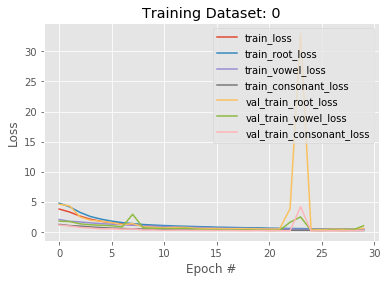

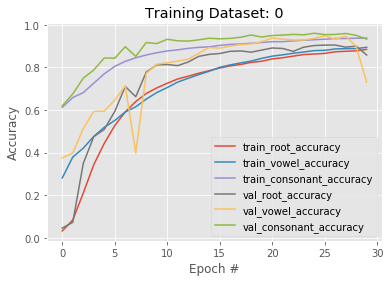

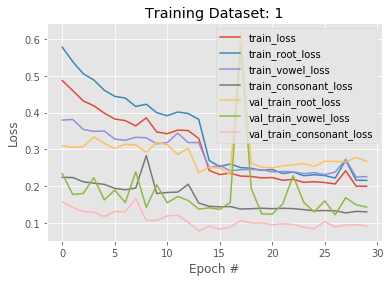

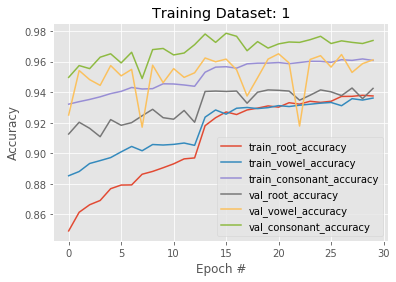

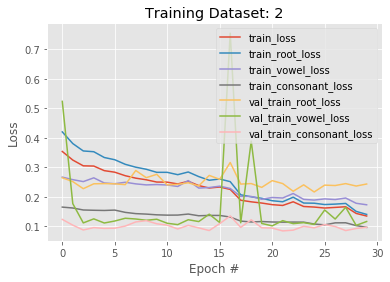

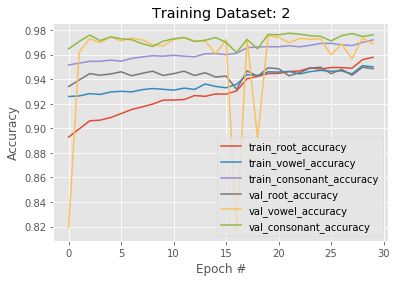

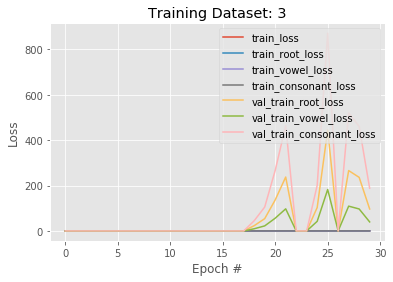

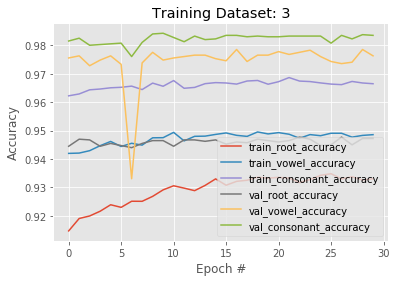

In [27]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [28]:
del histories
gc.collect()

30216

In [29]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [30]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet(DATA_FOLDER + f'/test_image_data_{i}.parquet') 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, size=IMG_SIZE,need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93


In [31]:
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
